# Accuracy verification

Test models with different parameters and compare the accuracy.

In [10]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

In [11]:
dfh = pd.read_csv('./data/[1h]BTCUSDT.csv')
dfm = pd.read_csv('./data/[1m]BTCUSDT.csv')

In [12]:
dfh['Start'] = pd.to_datetime(dfh['Start'].to_numpy(), unit='ms')
dfh['Stop'] = pd.to_datetime(dfh['Stop'].to_numpy(), unit='ms')

dfm['Start'] = pd.to_datetime(dfm['Start'].to_numpy(), unit='ms')
dfm['Stop'] = pd.to_datetime(dfm['Stop'].to_numpy(), unit='ms')

In [13]:
display(dfh)
display(dfm)

,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 04:00:00,2017-08-17 04:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 05:00:00,2017-08-17 05:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 06:00:00,2017-08-17 06:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807
...,...,...,...,...,...,...,...
29471,2020-12-31 20:00:00,2020-12-31 20:59:59.999,28897.84,29126.70,28862.00,29139.65,1936.480299
29472,2020-12-31 21:00:00,2020-12-31 21:59:59.999,29126.71,28966.36,28900.79,29169.55,2524.473111
29473,2020-12-31 22:00:00,2020-12-31 22:59:59.999,28966.36,29100.84,28910.19,29143.73,1438.506326
29474,2020-12-31 23:00:00,2020-12-31 23:59:59.999,29100.83,28923.63,28780.00,29110.35,1976.419299


,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 04:00:00,2017-08-17 04:00:59.999,4261.48,4261.48,4261.48,4261.48,1.775183
1,2017-08-17 04:01:00,2017-08-17 04:01:59.999,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:02:00,2017-08-17 04:02:59.999,4280.56,4280.56,4280.56,4280.56,0.261074
3,2017-08-17 04:03:00,2017-08-17 04:03:59.999,4261.48,4261.48,4261.48,4261.48,0.012008
4,2017-08-17 04:04:00,2017-08-17 04:04:59.999,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...,...,...
1767788,2020-12-31 23:56:00,2020-12-31 23:56:59.999,28978.91,28975.06,28969.99,28988.06,19.086172
1767789,2020-12-31 23:57:00,2020-12-31 23:57:59.999,28975.06,28975.03,28955.35,28981.41,21.327772
1767790,2020-12-31 23:58:00,2020-12-31 23:58:59.999,28975.03,28923.67,28923.15,28977.10,36.070975
1767791,2020-12-31 23:59:00,2020-12-31 23:59:59.999,28923.66,28923.63,28903.86,28952.28,51.895343


In [14]:
x = dfm['Stop']
y = dfm['Close']

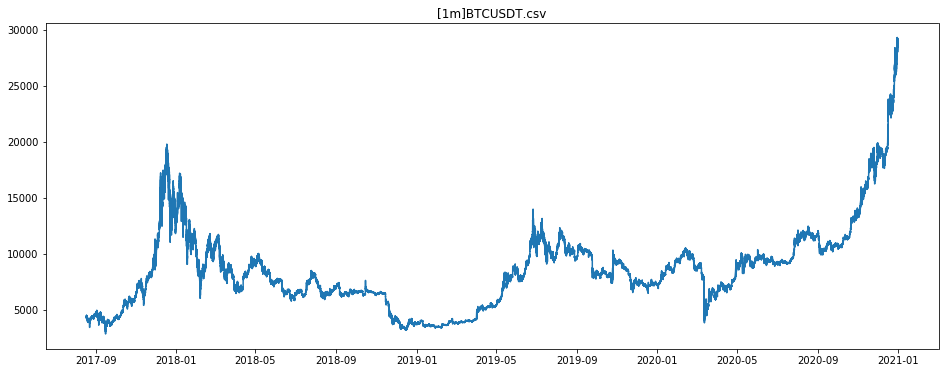

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(x, y)
plt.title('[1m]BTCUSDT.csv')
plt.show()

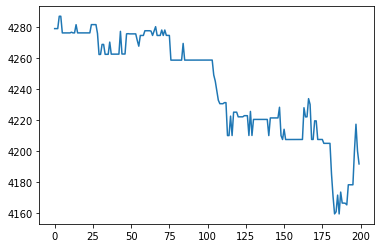

In [16]:
X = y[33400:33600].to_numpy()
plt.plot(X);

In [17]:
# initial training size
size = len(X) - 25
train, test = X[0:size], X[size:len(X)]

In [18]:
experiments = []
for p in [0, 1, 2]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            experiment = {
                'p': p,
                'd': d,
                'q': q,
            }

            history = train.tolist()
            predictions = train.tolist()
            errors = [0] * len(history)
            time_spend = 0

            for t in range(len(test)):
                model = ARIMA(history, order=(p, d, q))
                cur_time = time.time()
                model_fit = model.fit()
                time_spend = time_spend + (time.time() - cur_time)
                
                prediction = model_fit.forecast()[0]
                predictions.append(prediction)

                true = test[t]
                history.append(true)

                # error
                error = np.abs(true - prediction)
                errors.append(error)
                
            # evaluate forecasts
            rmse = np.sqrt(mean_squared_error(X, predictions))
            time_spend = time_spend / len(test)
            experiment['rmse'] = rmse
            experiment['time_spend'] = time_spend
            print(experiment)
            experiment['predictions'] = predictions
            experiment['errors'] = errors
            experiments.append(experiment)

{'p': 0, 'd': 0, 'q': 0, 'rmse': 22.48196557289922, 'time_spend': 0.16406163215637207}
{'p': 0, 'd': 0, 'q': 1, 'rmse': 12.193069063787274, 'time_spend': 0.2011198043823242}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'p': 0, 'd': 0, 'q': 2, 'rmse': 8.803353202441125, 'time_spend': 0.37813194274902345}
{'p': 0, 'd': 1, 'q': 0, 'rmse': 3.5621303316975816, 'time_spend': 0.02424481391906738}
{'p': 0, 'd': 1, 'q': 1, 'rmse': 3.8439998074729296, 'time_spend': 0.059505033493041995}
{'p': 0, 'd': 1, 'q': 2, 'rmse': 3.82088297322764, 'time_spend': 0.07302111625671387}
{'p': 0, 'd': 2, 'q': 0, 'rmse': 4.7432294905457555, 'time_spend': 0.020172872543334962}
{'p': 0, 'd': 2, 'q': 1, 'rmse': 3.565821057105545, 'time_spend': 0.18156265258789062}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'p': 0, 'd': 2, 'q': 2, 'rmse': 3.8649770937059666, 'time_spend': 0.35853821754455567}
{'p': 1, 'd': 0, 'q': 0, 'rmse': 3.591908268521394, 'time_spend': 0.21054245948791503}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'p': 1, 'd': 0, 'q': 1, 'rmse': 3.8536157353318297, 'time_spend': 0.5124839496612549}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'p': 1, 'd': 0, 'q': 2, 'rmse': 3.833481499874983, 'time_spend': 0.7163830757141113}
{'p': 1, 'd': 1, 'q': 0, 'rmse': 3.7524368600211297, 'time_spend': 0.10445028305053711}
{'p': 1, 'd': 1, 'q': 1, 'rmse': 3.832011432176232, 'time_spend': 0.25919795989990235}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'p': 1, 'd': 1, 'q': 2, 'rmse': 3.872317255420417, 'time_spend': 0.7073846817016601}
{'p': 1, 'd': 2, 'q': 0, 'rmse': 4.339862243137627, 'time_spend': 0.0913379955291748}
{'p': 1, 'd': 2, 'q': 1, 'rmse': 3.7591190693295315, 'time_spend': 0.3472049903869629}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'p': 1, 'd': 2, 'q': 2, 'rmse': 3.893863591280592, 'time_spend': 0.6534007167816163}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'p': 2, 'd': 0, 'q': 0, 'rmse': 3.7684214806219676, 'time_spend': 0.3196883678436279}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

{'p': 2, 'd': 0, 'q': 1, 'rmse': 3.840347752040591, 'time_spend': 0.6661534309387207}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

{'p': 2, 'd': 0, 'q': 2, 'rmse': 3.876855141713598, 'time_spend': 0.6863730812072754}
{'p': 2, 'd': 1, 'q': 0, 'rmse': 3.828108193905522, 'time_spend': 0.06185877799987793}
{'p': 2, 'd': 1, 'q': 1, 'rmse': 3.8379544074758303, 'time_spend': 0.15605642318725585}
{'p': 2, 'd': 1, 'q': 2, 'rmse': 3.8821937508103526, 'time_spend': 0.24588712692260742}
{'p': 2, 'd': 2, 'q': 0, 'rmse': 4.352557005194002, 'time_spend': 0.09252238273620605}
{'p': 2, 'd': 2, 'q': 1, 'rmse': 3.8477167613071983, 'time_spend': 0.450556116104126}
{'p': 2, 'd': 2, 'q': 2, 'rmse': 3.9748245187618765, 'time_spend': 0.8025358009338379}


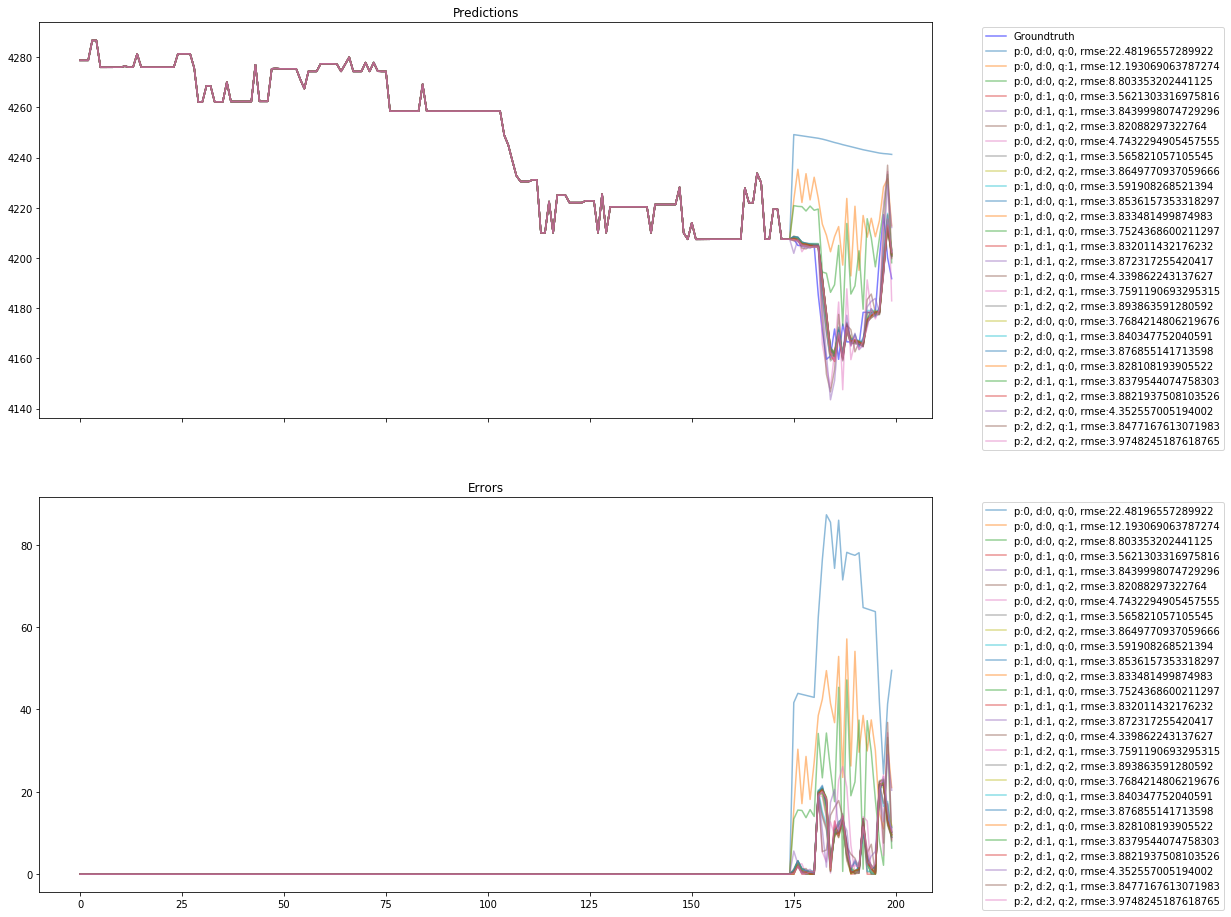

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), sharex=True)
ax1.plot(X, color='blue', label='Groundtruth', alpha=0.5)

for e in experiments:
    e_name = f"p:{e['p']}, d:{e['d']}, q:{e['q']}, rmse:{e['rmse']}"
                
    ax1.plot(e['predictions'], label=e_name, alpha=0.5)
    ax2.plot(e['errors'], label=e_name, alpha=0.5)

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title('Predictions')
ax2.set_title('Errors')
plt.show()

In [20]:
results = pd.DataFrame(data={
    'p': [e['p'] for e in experiments],
    'd': [e['d'] for e in experiments],
    'q': [e['q'] for e in experiments],
    'RMSE': [e['rmse'] for e in experiments],
    'Average training time (sec)': [e['time_spend'] for e in experiments],
}).sort_values('RMSE')

In [21]:
results

,p,d,q,RMSE,Average training time (sec)
3,0,1,0,3.562130,0.024245
7,0,2,1,3.565821,0.181563
9,1,0,0,3.591908,0.210542
12,1,1,0,3.752437,0.104450
16,1,2,1,3.759119,0.347205
18,2,0,0,3.768421,0.319688
5,0,1,2,3.820883,0.073021
21,2,1,0,3.828108,0.061859
13,1,1,1,3.832011,0.259198
11,1,0,2,3.833481,0.716383


# Results

Time Series forecasting models are very sensitive to the model parameters.  
There are a lot of methods to estimate the model parameteres such as MINIC, SCAN, ESACF.  
For example, if we use (0, 1, 0) parameters for ARIMA, we will get the approximately same accuracy as with (0, 2, 1), but the training time is much bigger.  
There is a trade-off in accuracy and performance of the model.